<h2> Inversion of a single data point </h2>
This notebook is meant to serve as a framework for future inversion and interpolation of many data points. <br>
Detailed commentary on each inversion step is available in ~/SimPEG_examples/plot_inv_1_em1dfm.ipnyb

<h3> Imports

In [1]:
# Module imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from discretize import TensorMesh

import simpeg.electromagnetics.frequency_domain as fdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

<h3> Data Import and Sounding Visualization

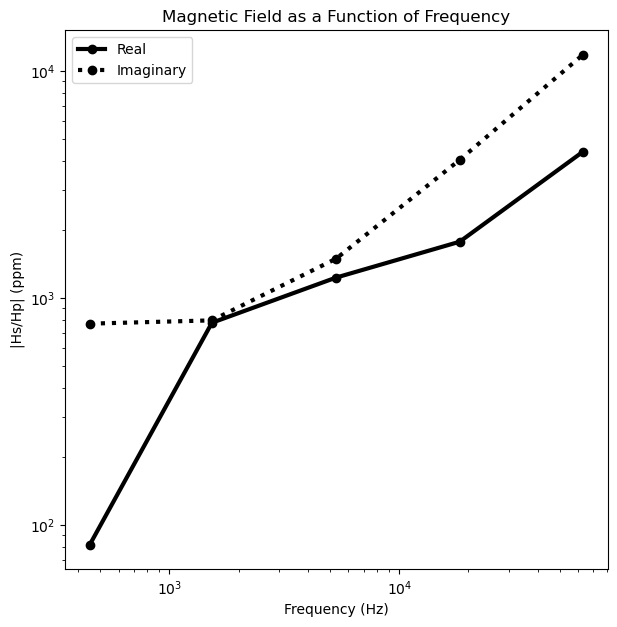

In [2]:
# Data import
df = pd.read_csv('../data/gem2_combined.csv')

# Visualization of one point
# Choses the first survey point
dobs = np.empty(0)
frequencies = [450, 1530, 5310, 18330, 63030]
for i in range(len(frequencies)):
    dobs = np.append(dobs, df.loc[0][f'I_{frequencies[i]}Hz [ppm]'])
    dobs = np.append(dobs, df.loc[0][f'Q_{frequencies[i]}Hz [ppm]'])

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.loglog(frequencies, np.abs(dobs[0::2]), "k-o", lw=3)
ax.loglog(frequencies, np.abs(dobs[1::2]), "k:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Hs/Hp| (ppm)")
ax.set_title("Magnetic Field as a Function of Frequency")
ax.legend(["Real", "Imaginary"])

<h3> Source and Receiver Setup

In [3]:
# Figuring out Tx and Rx positions
# Assumed perfectly east west movement with reciever to the west
# 1.6 m offset
# 1/2 ft above the ground
h = 6 * 2.54
x_0, y_0 = df.loc[0]['Easting [m]'], df.loc[0]['Northing [m]']
source_location = np.array([x_0 + 0.8, y_0, h])
receiver_location = np.array([x_0 - 0.8, y_0, h])

# Reciever and moment setup
moment = 3 # A-m^2, taken from geophex website for gem2
receiver_orientation = "z"
data_type = "ppm"

# Receiver list
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="imag",
    )
)

# Define source list
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation="z",
            moment=moment,
        )
    )

# Survey
survey = fdem.survey.Survey(source_list)

<h3> Uncertainty

In [4]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

# Define the data object
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

<h3> Defining a 1D Layered Earth

In [15]:
# Layer thicknesses
inv_thicknesses = np.logspace(0, 1.5, num = 10)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")

<h3> Defining a Starting Model

In [16]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(0.1 * np.ones(mesh.nC))

# Define mapping from model to active cells.
model_mapping = maps.ExpMap()

<h3> Setting Up a Simulation Object

In [17]:
simulation = fdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

<h3> Defining Inverse Problem

In [18]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg_map = maps.IdentityMap(nP=mesh.nC)
reg = regularization.Sparse(mesh, mapping=reg_map, alpha_s=0.025, alpha_x=1.0)

# reference model
reg.reference_model = starting_model

# Define sparse and blocky norms p, q
reg.norms = [0, 0]

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(maxIter=50, maxIterLS=20, maxIterCG=30, tolCG=1e-3)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
inv_prob

<h3> Defining Inversion Directives

In [19]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Update the preconditionner
update_Jacobi = directives.UpdatePreconditioner()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Directive for the IRLS
update_IRLS = directives.UpdateIRLS(max_irls_iterations=30, irls_cooling_factor=1.5)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_IRLS,
    update_jacobi,
]

<h3> Running Inversion

In [20]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.95e-01  3.82e+03  0.00e+00  3.82e+03    4.21e+01      0              
   1  4.47e-01  3.15e+03  1.49e+00  3.15e+03    1.46e+02      4              
   2  2.24e-01  2.91e+03  3.36e+00  2.91e+03    3.87e+01      4              
   3  1.12e-01  2.90e+03  4.47e+00  2.90e+03    7.95e+01      6              
   4  5.59e-02  2.90e+03  6.68e+00  2.90e+03    1.51e+02      6   Skip BFGS  
   5  2.80e-02  2.90e+03  8.36e+00  2.90e+03    1.73e+02      7   Skip B

<h3> Plotting Results

In [21]:
# Load the true model and layer thicknesses
true_model = np.array([0.1, 1.0, 0.1])
true_layers = np.r_[20.0, 40.0, 160.0]

# Extract Least-Squares model
l2_model = inv_prob.l2model

# Plot true model and recovered model
fig = plt.figure(figsize=(8, 9))
x_min = np.min(
    np.r_[model_mapping * recovered_model, model_mapping * l2_model, true_model]
)
x_max = np.max(
    np.r_[model_mapping * recovered_model, model_mapping * l2_model, true_model]
)

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_model, ax=ax1, show_layers=False, color="k")
plot_1d_layer_model(
    mesh.h[0], model_mapping * l2_model, ax=ax1, show_layers=False, color="b"
)
plot_1d_layer_model(
    mesh.h[0], model_mapping * recovered_model, ax=ax1, show_layers=False, color="r"
)
ax1.set_xlim(0.01, 10)
ax1.set_title("True and Recovered Models")
ax1.legend(["True Model", "L2-Model", "Sparse Model"])
plt.gca().invert_yaxis()

# Plot predicted and observed data
dpred_l2 = simulation.dpred(l2_model)
dpred_final = simulation.dpred(recovered_model)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(frequencies, np.abs(dobs[0::2]), "k-o")
ax1.loglog(frequencies, np.abs(dobs[1::2]), "k:o")
ax1.loglog(frequencies, np.abs(dpred_l2[0::2]), "b-o")
ax1.loglog(frequencies, np.abs(dpred_l2[1::2]), "b:o")
ax1.loglog(frequencies, np.abs(dpred_final[0::2]), "r-o")
ax1.loglog(frequencies, np.abs(dpred_final[1::2]), "r:o")
ax1.set_xlabel("Frequencies (Hz)")
ax1.set_ylabel("|Hs/Hp| (ppm)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(
    [
        "Observed (real)",
        "Observed (imag)",
        "L2-Model (real)",
        "L2-Model (imag)",
        "Sparse (real)",
        "Sparse (imag)",
    ],
    loc="upper left",
)
plt.show()

AttributeError: 'BaseInvProblem' object has no attribute 'l2model'